<a href="https://colab.research.google.com/github/hoangnuthuphuong/Machine_Learning/blob/main/Chuong5_HuanLuyenMoHinh_%26_Loi/C5_BTKN04_1_kFoldCV_vs_HQTT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Quy trình xây dựng k-fold cross-validation**

Sau khi chia tập dữ liệu D ban đầu thành 2 tập train – test với tỉ lệ thông thường là 70% -
30%, quá trình huấn luyện diễn ra với tập $D_{train}$ được tiến hành bằng cách lấy ra từ $D_{train}$ một phần nhỏ dữ liệu làm *tập dữ liệu kiểm thử cho bước huấn luyện thứ i* – gọi là $D_{validation}. Phần dữ liệu còn lại đóng vai trò là tập dữ liệu huấn luyện. Quá trình này lặp lại nhiều lần cho đến khi mô hình huấn luyện đạt được yêu cầu. Tóm lại, quy trình thực hiện *k-fold cross-validation* (với k thông thường được chọn k = 10 – nên gọi là *10-fold cross-validation*) được tóm tắt như sau:

- Bước 1: Đọc dữ liệu gốc D
- Bước 2: Điều chỉnh dữ liệu
- Bước 3: Chia train – test theo tỉ lệ (thông thường là 70% - 30%)
- Bước 4: Xác định k
- Bước 5: Thực hiện huấn luyên mô hình với k-fold cross validation
- Bước 6: Kiểm định mô hình với tập dữ liệu test

Minh họa quy trình này với 5-fold cross-validation theo ví dụ của [sklearn](https://scikit-learn.org/stable/modules/cross_validation.html)

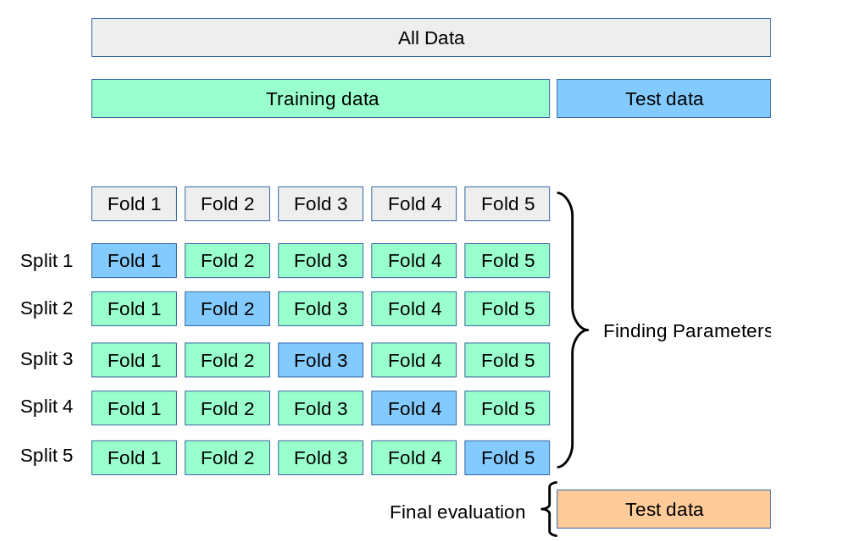

$$ ----------------------------------------$$

$$ ----------------------------------------$$

# **2. Huấn luyện mô hình HQTT với 10-fold CV sử dụng Gradient Descent**

In [ ]:
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

**Bước 1:** Đọc dữ liệu

In [ ]:
def readData(folder , filename):
    data = np.loadtxt(os.path.join(folder, filename), delimiter = ',')
    X = data[:, :-1]
    y = data[:, -1].reshape(-1, 1)
    one = np.ones((X.shape[0], 1))
    X = np.concatenate((one, X), axis = 1)
    return X, y

In [ ]:
# Hàm dự đoán
def predict(X, w):
    return np.dot(X, w)

In [ ]:
def loss(X, y, w):
    h = np.dot(X, w)
    m = X.shape[0]
    J = (1/ (2*m)) * np.sum(np.square(h-y))
    return J

In [ ]:
def gradient(X, y, w):
    m = X.shape[0]
    h = np.dot(X, w)
    return (1/m) * np.dot(X.T, h - y)

In [ ]:
def gradientDescent(X, y, w_init, alpha, n = 1500):
    w_optimal = w_init.reshape(-1, 1)
    loss_values = []
    for i in range(n):
        w_optimal = w_optimal - alpha * gradient(X, y, w_optimal)
        j = loss(X, y, w_optimal)
        loss_values.append(j)
    return w_optimal, loss_values

**Bước 2 + 3:** Điều chỉnh dữ liệu & Phân chia train - test theo tỉ lệ 70% - 30%
> Đây là mô hình HQTT nên chấp nhận scale cả vector y

In [ ]:
def featureScalingSplit(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_train[:, 1:] = sc_X.fit_transform(X_train[:, 1:])
    X_test[:, 1:] = sc_X.transform(X_test[:, 1:])
    y_train = sc_y.fit_transform(y_train)
    y_test = sc_y.transform(y_test)
    return X_train, X_test, y_train, y_test

**Bước 4 + 5:** Xác định k-fold và Huấn luyện mô hình

In [ ]:
def kFoldCrossValiation(X_train, y_train):
    # Xác định k-fold
    kf = KFold(n_splits=10)

    # Huấn luyện mô hình
    w_init = np.zeros((X_train.shape[1], 1))
    step = 0
    valitdate_models = {}
    for train2_index, val_index in kf.split(X = X_train,y = y_train):
        step = step + 1
        print('\tBước lặp huấn luyện thứ: ', step)
        X_train2, X_val = X_train[train2_index], X_train[val_index]
        y_train2, y_val = y_train[train2_index], y_train[val_index]
        w_opt, J_history = gradientDescent(X=X_train2,y=y_train2, 
                                           w_init=w_init, alpha=0.01, n=1500)
        print('\t\tĐánh giá mô hình trên tập dữ liệu validation')
        y_pred = predict(X_val, w_opt)
        print('\t\t\tMSE: ', mean_squared_error(y_val, y_pred))
        valitdate_models[mean_squared_error(y_val, y_pred)] = w_opt 
    min_error = min(list(valitdate_models.keys()))
    return valitdate_models[min_error]

**Bước 6:** Kiểm định mô hình với tập dữ liệu test

In [ ]:
def validateTestSet(X_test, y_test, w_opt):
    print("\n\tĐánh giá hiệu năng mô hình trên tập dữ liệu test:")
    y_pred = predict(X_test, w_opt)
    print("\t\tMSE: ", mean_squared_error(y_test, y_pred))
    return mean_squared_error(y_test, y_pred)

In [ ]:
def main():
    X, y = readData('/content/drive/MyDrive/Classroom/Học máy 1 Phần cơ sở', 'ex1data1.txt')
    X_train, X_test, y_train, y_test = featureScalingSplit(X, y)
    w_optimal = kFoldCrossValiation(X_train, y_train)
    validateTestSet(X_test, y_test, w_optimal)
    
if __name__ == "__main__":
    main()

	Bước lặp huấn luyện thứ:  1
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.09846244189901625
	Bước lặp huấn luyện thứ:  2
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.309333329723167
	Bước lặp huấn luyện thứ:  3
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.27867500943376566
	Bước lặp huấn luyện thứ:  4
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.7930819036225498
	Bước lặp huấn luyện thứ:  5
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.25094177050851435
	Bước lặp huấn luyện thứ:  6
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.37852766444851904
	Bước lặp huấn luyện thứ:  7
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.16997987696222122
	Bước lặp huấn luyện thứ:  8
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.3111658363868637
	Bước lặp huấn luyện thứ:  9
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.2522728184714143
	Bước lặp huấn luyện thứ:  10
		Đánh giá mô hình trên tập dữ

$$ ----------------------------------------$$

$$ ----------------------------------------$$

# **3. Huấn luyện mô hình HQTT với 10-fold CV sử dụng LinearRegression**

In [ ]:
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

**Bước 1:** Đọc dữ liệu

In [ ]:
def readData(folder , filename):
    data = np.loadtxt(os.path.join(folder, filename), delimiter = ',')
    X = data[:, :-1]
    y = data[:, -1].reshape(-1, 1)
    one = np.ones((X.shape[0], 1))
    X = np.concatenate((one, X), axis = 1)
    return X, y

**Bước 3:** Điều chỉnh dữ liệu & Phân chia train - test theo tỉ lệ 70% - 30%
> Đây là mô hình HQTT nên chấp nhận scale cả vector y

In [ ]:
def featureScalingSplit(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_train[:, 1:] = sc_X.fit_transform(X_train[:, 1:])
    X_test[:, 1:] = sc_X.transform(X_test[:, 1:])
    y_train = sc_y.fit_transform(y_train)
    y_test = sc_y.transform(y_test)
    return X_train, X_test, y_train, y_test

**Bước 4 + 5:** Xác định k-fold và Huấn luyện mô hình

In [ ]:
def kFoldCrossValiation(X_train, y_train):
    # Xác định k-fold
    kf = KFold(n_splits=10)
    # Huấn luyện mô hình sử dụng Linear regression
    step = 0
    valitdate_models = {}
    for train2_index, val_index in kf.split(X = X_train,y = y_train):
        step = step + 1
        regressor = LinearRegression()
        print('\tBước lặp huấn luyện thứ: ', step)
        X_train2, X_val = X_train[train2_index], X_train[val_index]
        y_train2, y_val = y_train[train2_index], y_train[val_index]
        regressor.fit(X_train2, y_train2)
        print('\t\tĐánh giá mô hình trên tập dữ liệu validation')
        y_pred = regressor.predict(X_val)
        print('\t\t\tMSE: ', mean_squared_error(y_val, y_pred))
        valitdate_models[mean_squared_error(y_val, y_pred)] =  regressor
    min_error = min(list(valitdate_models.keys()))
    return valitdate_models[min_error]

**Bước 6:** Kiểm định mô hình với tập dữ liệu test

In [ ]:
def validateTestSet(X_test, y_test, regressor):
    print("\n\tĐánh giá hiệu năng mô hình trên tập dữ liệu test:")
    y_pred = regressor.predict(X_test)
    print("\t\tMSE: ", mean_squared_error(y_test, y_pred))
    return mean_squared_error(y_test, y_pred)

In [ ]:
def main():
    X, y = readData('/content/drive/MyDrive/Classroom/Học máy 1 Phần cơ sở', 'ex1data1.txt')
    X_train, X_test, y_train, y_test = featureScalingSplit(X, y)
    regressor = kFoldCrossValiation(X_train, y_train)
    validateTestSet(X_test, y_test, regressor)
    
if __name__ == "__main__":
    main()

	Bước lặp huấn luyện thứ:  1
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.09846242378721601
	Bước lặp huấn luyện thứ:  2
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.30933337514213416
	Bước lặp huấn luyện thứ:  3
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.2786751422632196
	Bước lặp huấn luyện thứ:  4
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.7930819695980855
	Bước lặp huấn luyện thứ:  5
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.25094170781690417
	Bước lặp huấn luyện thứ:  6
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.3785276488735265
	Bước lặp huấn luyện thứ:  7
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.16997080810637985
	Bước lặp huấn luyện thứ:  8
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.31117226307922113
	Bước lặp huấn luyện thứ:  9
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.25227276442757546
	Bước lặp huấn luyện thứ:  10
		Đánh giá mô hình trên tập 

$$ ----------------------------------------$$

$$ ----------------------------------------$$

# **4. Huấn luyện mô hình HQTT với 10-fold CV sử dụng Lasso**

In [ ]:
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso

In [ ]:
def readData(folder , filename):
    data = np.loadtxt(os.path.join(folder, filename), delimiter = ',')
    X = data[:, :-1]
    y = data[:, -1].reshape(-1, 1)
    one = np.ones((X.shape[0], 1))
    X = np.concatenate((one, X), axis = 1)
    return X, y

In [ ]:
def featureScalingSplit(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_train[:, 1:] = sc_X.fit_transform(X_train[:, 1:])
    X_test[:, 1:] = sc_X.transform(X_test[:, 1:])
    y_train = sc_y.fit_transform(y_train)
    y_test = sc_y.transform(y_test)
    return X_train, X_test, y_train, y_test


In [ ]:
def kFoldCrossValiation(X_train, y_train):
    kf = KFold(n_splits=10)
    step = 0
    valitdate_models = {}
    for train2_index, val_index in kf.split(X = X_train,y = y_train):
        step = step + 1
        regressor = Lasso()
        print('\tBước lặp huấn luyện thứ: ', step)
        X_train2, X_val = X_train[train2_index], X_train[val_index]
        y_train2, y_val = y_train[train2_index], y_train[val_index]
        regressor.fit(X_train2, y_train2)
        print('\t\tĐánh giá mô hình trên tập dữ liệu validation')
        y_pred = regressor.predict(X_val)
        print('\t\t\tMSE: ', mean_squared_error(y_val, y_pred))
        valitdate_models[mean_squared_error(y_val, y_pred)] =  regressor
    min_error = min(list(valitdate_models.keys()))
    return valitdate_models[min_error]

In [ ]:
def validateTestSet(X_test, y_test, regressor):
    print("\n\tĐánh giá hiệu năng mô hình trên tập dữ liệu test:")
    y_pred = regressor.predict(X_test)
    print("\t\tMSE: ", mean_squared_error(y_test, y_pred))
    return mean_squared_error(y_test, y_pred)

In [ ]:
def main():
    X, y = readData('/content/drive/MyDrive/Classroom/Học máy 1 Phần cơ sở', 'ex1data1.txt')
    X_train, X_test, y_train, y_test = featureScalingSplit(X, y)
    regressor = kFoldCrossValiation(X_train, y_train)
    validateTestSet(X_test, y_test, regressor)
    
if __name__ == "__main__":
    main()


	Bước lặp huấn luyện thứ:  1
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.38869062164645946
	Bước lặp huấn luyện thứ:  2
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.476381813420898
	Bước lặp huấn luyện thứ:  3
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.12959114673149702
	Bước lặp huấn luyện thứ:  4
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.9785600586379284
	Bước lặp huấn luyện thứ:  5
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.6804212163657127
	Bước lặp huấn luyện thứ:  6
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.8741806353418291
	Bước lặp huấn luyện thứ:  7
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  2.441122014142207
	Bước lặp huấn luyện thứ:  8
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  1.7132674547715212
	Bước lặp huấn luyện thứ:  9
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.572079005829643
	Bước lặp huấn luyện thứ:  10
		Đánh giá mô hình trên tập dữ liệu

$$ ----------------------------------------$$

$$ ----------------------------------------$$

# **5. Huấn luyện mô hình HQTT với 10-fold CV sử dụng Ridge**

In [ ]:
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

In [ ]:
def readData(folder , filename):
    data = np.loadtxt(os.path.join(folder, filename), delimiter = ',')
    X = data[:, :-1]
    y = data[:, -1].reshape(-1, 1)
    one = np.ones((X.shape[0], 1))
    X = np.concatenate((one, X), axis = 1)
    return X, y

In [ ]:
def featureScalingSplit(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_train[:, 1:] = sc_X.fit_transform(X_train[:, 1:])
    X_test[:, 1:] = sc_X.transform(X_test[:, 1:])
    y_train = sc_y.fit_transform(y_train)
    y_test = sc_y.transform(y_test)
    return X_train, X_test, y_train, y_test

In [ ]:
def kFoldCrossValiation(X_train, y_train):
    kf = KFold(n_splits=10)
    step = 0
    valitdate_models = {}
    for train2_index, val_index in kf.split(X = X_train,y = y_train):
        step = step + 1
        regressor = Ridge()
        print('\tBước lặp huấn luyện thứ: ', step)
        X_train2, X_val = X_train[train2_index], X_train[val_index]
        y_train2, y_val = y_train[train2_index], y_train[val_index]
        regressor.fit(X_train2, y_train2)
        print('\t\tĐánh giá mô hình trên tập dữ liệu validation')
        y_pred = regressor.predict(X_val)
        print('\t\t\tMSE: ', mean_squared_error(y_val, y_pred))
        valitdate_models[mean_squared_error(y_val, y_pred)] =  regressor
    min_error = min(list(valitdate_models.keys()))
    return valitdate_models[min_error]

In [ ]:
def validateTestSet(X_test, y_test, regressor):
    print("\n\tĐánh giá hiệu năng mô hình trên tập dữ liệu test:")
    y_pred = regressor.predict(X_test)
    print("\t\tMSE: ", mean_squared_error(y_test, y_pred))
    return mean_squared_error(y_test, y_pred)

In [ ]:
def main():
    X, y = readData('/content/drive/MyDrive/Classroom/Học máy 1 Phần cơ sở', 'ex1data1.txt')
    X_train, X_test, y_train, y_test = featureScalingSplit(X, y)
    regressor = kFoldCrossValiation(X_train, y_train)
    validateTestSet(X_test, y_test, regressor)
    
if __name__ == "__main__":
    main()

	Bước lặp huấn luyện thứ:  1
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.10027355282708982
	Bước lặp huấn luyện thứ:  2
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.3050352526830756
	Bước lặp huấn luyện thứ:  3
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.2695943720430736
	Bước lặp huấn luyện thứ:  4
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.7937309445324597
	Bước lặp huấn luyện thứ:  5
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.25515418014201396
	Bước lặp huấn luyện thứ:  6
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.381174270284043
	Bước lặp huấn luyện thứ:  7
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.18593155716108592
	Bước lặp huấn luyện thứ:  8
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.29722374454528183
	Bước lặp huấn luyện thứ:  9
		Đánh giá mô hình trên tập dữ liệu validation
			MSE:  0.25510641911465376
	Bước lặp huấn luyện thứ:  10
		Đánh giá mô hình trên tập dữ